In [1]:
#|default_exp accel

## Denoising Diffusion Probabilistic Models with miniai 

## Imports

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the Dataset 

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=7)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dt = dls.train
xb,yb = next(iter(dt))

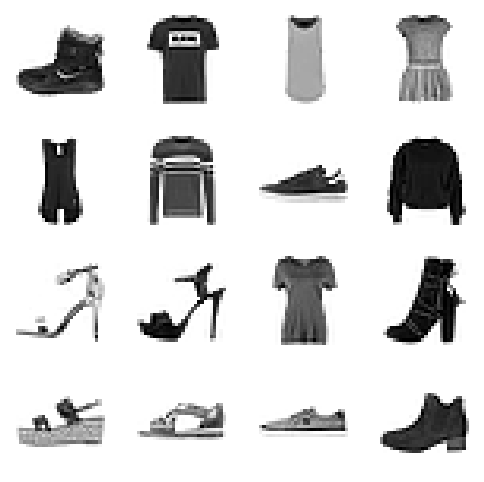

In [6]:
show_images(xb[:16], imsize=1.5);

In [7]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

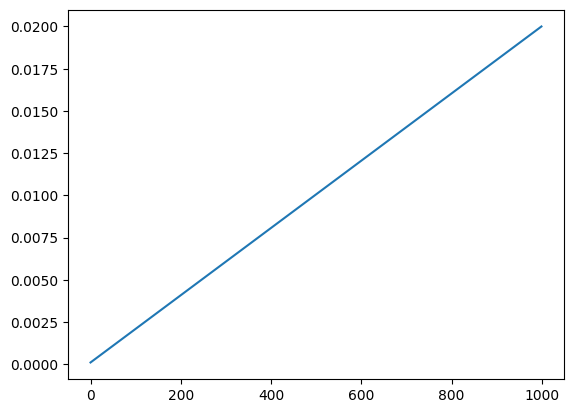

In [8]:
plt.plot(beta);

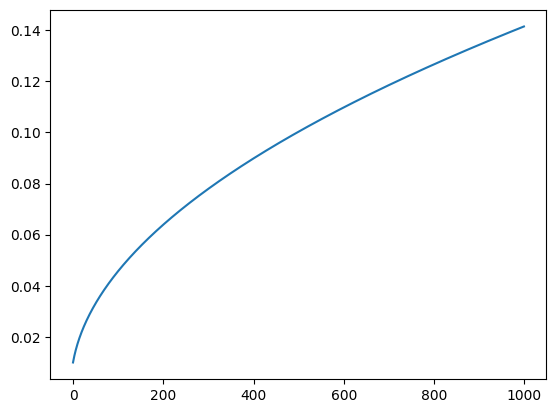

In [9]:
plt.plot(sigma);

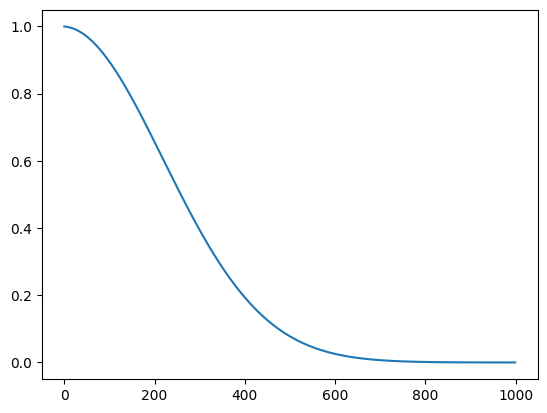

In [10]:
# Note that T=0 corresponds to no noise and sigma=0.
# Alphabar reflects the cumulative proportion of the original image that remains, 
# hence becomes effectively zero at T=1000
plt.plot(alphabar);

In [11]:
def noisify(x0, ᾱ):
    """ Function fo add noise to an image.  x0 is the image and alphabar is now much noise to add for
    a given t.  t is selected at random for each image in the batch
    """
    # Get device to use from x0
    device = x0.device
    # Define number of images to generate
    n = len(x0)
    # Create random value of t for each image
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)   
    # Create array of random numbers
    ε = torch.randn(x0.shape, device = device)
    # Scale noise by alphabar
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    # Add noise to image
    xt = ᾱ_t.sqrt() * x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [12]:
(xt, t), ε = noisify(xb[:25], alphabar)

In [13]:
t

tensor([312, 247, 856,  36, 531, 493, 732, 938, 266, 807, 249, 517, 419,   5,
        232, 325, 857, 846, 345,  58, 162, 905, 407, 430, 624])

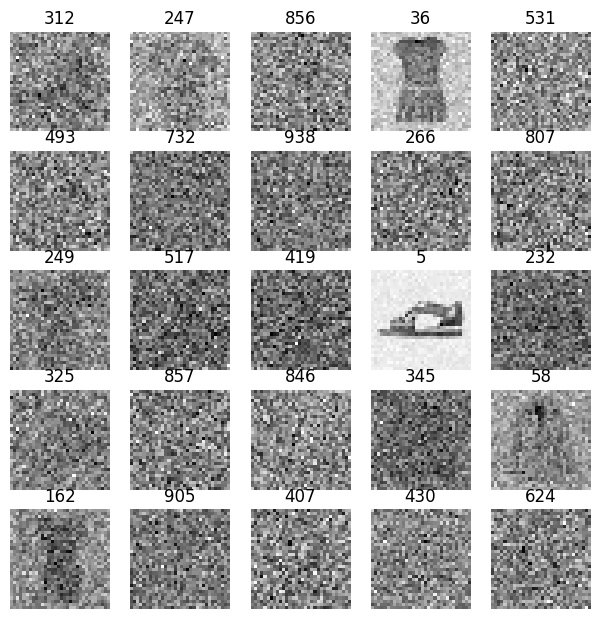

In [14]:
# Create a list of strings
titles = fc.map_ex(t, '{}')
show_images(xt, titles=titles, imsize=1.5)

## Training 

In [15]:
from diffusers import UNet2DModel

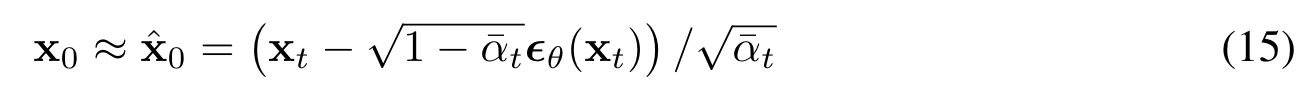
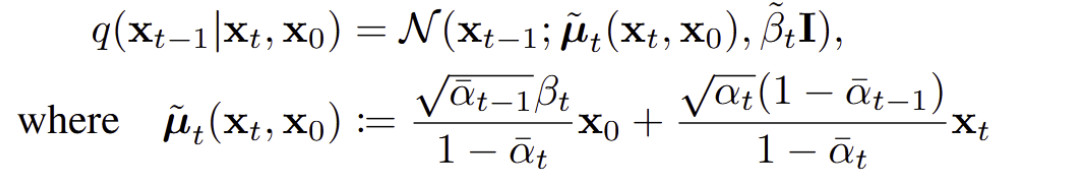

In [16]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        # Create an array if t's, all having the same value, with the length equal to the batch size
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        # Create the random noise array.  If t=0 then no noise added so make equal to zero
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        # Calculate the equation parameters
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        # Calculate x_0_hat (note the clamp is necessary fiven the divide by alphabar, which at high t becomes very small
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds


In [17]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

In [18]:
class UNet(UNet2DModel):
    """ Inherit from the Unet but modify the forward method.  This is needed since the default predict method
    passes in a tuple that contains the x_t and the time step.  This simply separates the tuple and passes in each item
    """
    # Note - very confusing but the .sample below is the way in which you get
    # predictions from the Huggingface model and is nothing to do with the sample function
    # of the callback.  Hence all this does is allow us to pass in a 
    def forward(self, x): return super().forward(*x).sample

In [19]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

Lets look at some noisified images that are fed to the model and the associated timesteps

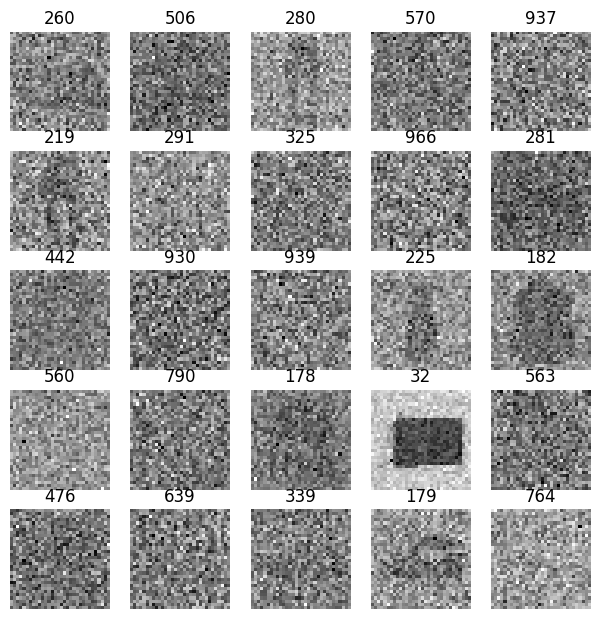

In [20]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

Now lets try some training

In [21]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [22]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

Create an initialization function for the model.  In this case use the orthogonal initialization in the down blocks and zeros in the up blocks

In [23]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [24]:
init_ddpm(model)

In [25]:
opt_func = partial(optim.Adam, eps=1e-5)

In [26]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.152,0,train
0.027,0,eval
0.024,1,train
0.022,1,eval
0.021,2,train
0.020,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.019,4,eval


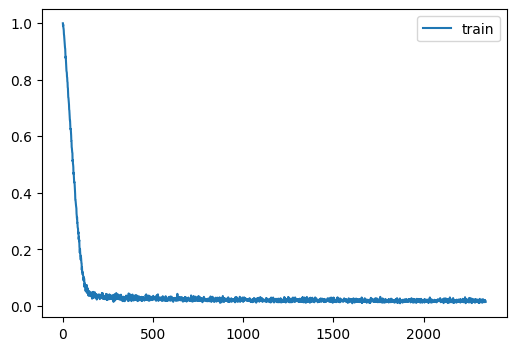

In [27]:
learn.fit(epochs)

In [28]:
mdl_path = Path('/home/models')

In [29]:
torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')

In [28]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

## Sampling 

In [30]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

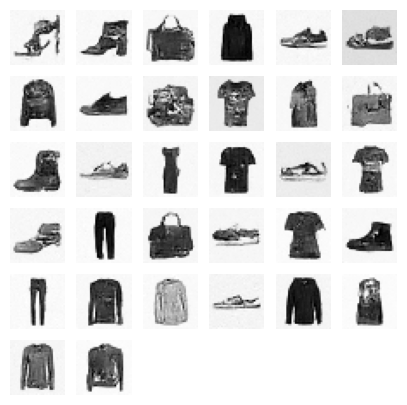

In [48]:
show_images(samples[-1], figsize=(5,5))

## Mixed Precision 
Lesson 20 - at the start

In [32]:
bs = 512

In [33]:
next(iter(DataLoader(tds['train'], batch_size=2, collate_fn=default_collate)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

Create a function to apply the noisification process using the dataloader

In [34]:
b = next(iter(DataLoader(tds['train'], batch_size=2)))

In [35]:
b[xl]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [49]:
def collate_ddpm(b): 
    """ default_collate returns the dict with keys image and label.  the Image key is 
    assigned to xl and hence we simply pass an array of images to noisify.  The labels are
    discarded.  Doing this allows us to remove the DDPMCB callback
    """
    return noisify(default_collate(b)[xl], alphabar)


In [37]:
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [38]:
# Create datalosers for the ddpm operation
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

Note that the following is based upon the pytorch docs for CUDA mixed precisions examples

In [39]:
#|export
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

Now use the mixed precision callback to train a model.  Since the batch size has been increased by a factor of 4 the model will train more slowly. To compensate for that we have increased the learning rate and trained for more epochs. Increasing the learning rate works with the initialisation defined above and with the larger than usual epsilon optimization function. Overall this trains about twice as quickly as the earlier model

In [40]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.269,0,train
0.032,0,eval
0.029,1,train
0.027,1,eval
0.024,2,train
0.023,2,eval
0.022,3,train
0.021,3,eval
0.020,4,train
0.020,4,eval


/home/c22penv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


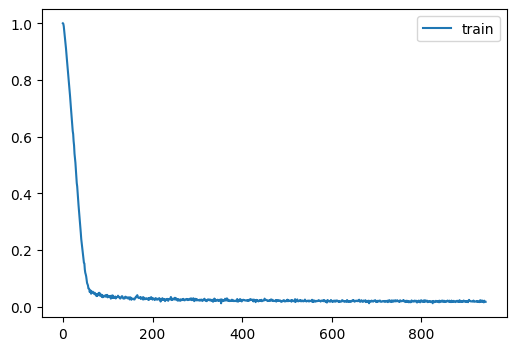

In [41]:
learn.fit(epochs)

In [42]:
samples = sample(learn.model, (32, 1, 32, 32), alpha, alphabar, sigma, n_steps)

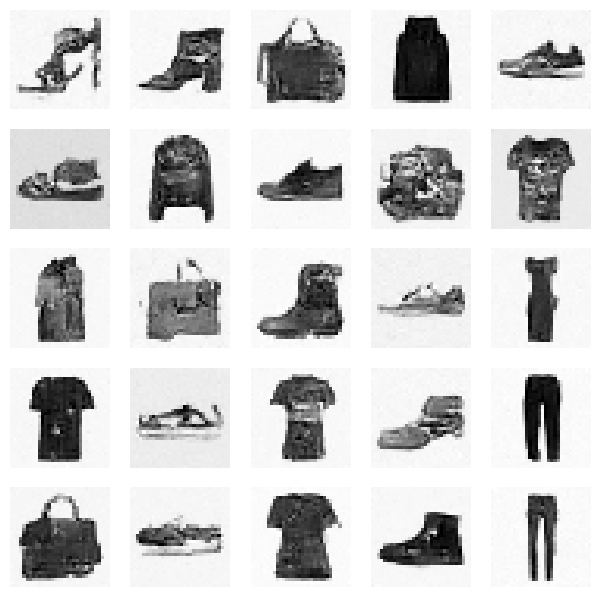

In [43]:
show_images(samples[-1][:25], imsize=1.5)

In [44]:
torch.save(learn.model, '/home/models/fashion_ddpm_mp.pkl')

## Accelerate 

Note that the accelerate module avoids the need for the mixed precision callback

In [58]:
#|export
from accelerate import Accelerator

In [59]:
#|export
class AccelerateCB(TrainCB):
    """ Create an accelerate callback using the Huggingface accelerator.  This inherits
    from TrainCB and hence allows us to overwrite backwards
    """
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): self.acc.backward(learn.loss)

Note that to avoid having to modify the model a new Learner parameter has been added that allows the number of inputs to be defined as a parameter.  This means that we an avoid the need to pass a tuple of x values, but we can pass two x values.  This simplifies the code and means we can use the default model without modification

In [65]:
def noisify(x0, ᾱ):
    """ Function fo add noise to an image.  x0 is the image and alphabar is now much noise to add for
    a given t.  t is selected at random for each image in the batch.
    Updated the output - no longer returns a tuple and then the target but the three values
    individually
    """
    # Get device to use from x0
    device = x0.device
    # Define number of images to generate
    n = len(x0)
    # Create random value of t for each image
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)   
    # Create array of random numbers
    ε = torch.randn(x0.shape, device = device)
    # Scale noise by alphabar
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    # Add noise to image
    xt = ᾱ_t.sqrt() * x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

In [66]:
# Recreate dataloader, not sure why as it looks the same as earlier
# Probably because dl_ddpm has been updated
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [67]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

Note that since AccelerateCB inherits from TrainCB we can pass n_in as a parameter when initializing the callback

In [68]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.264,0,train
0.033,0,eval
0.029,1,train
0.026,1,eval
0.024,2,train
0.024,2,eval
0.021,3,train
0.022,3,eval
0.020,4,train
0.020,4,eval


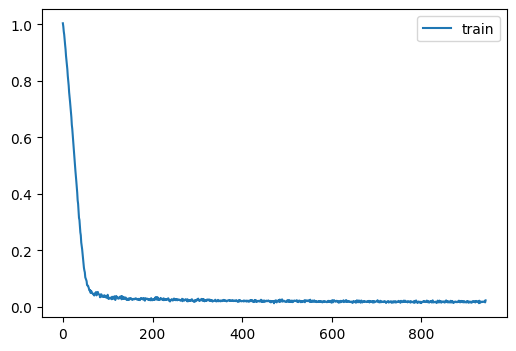

In [69]:
learn.fit(epochs)

## A sneaky trick 

This is a way to maximize the utilization of GPUs when there is a limited cpu capacity.  What it does is to return multiple copies of the data for each epoch.

In [47]:
class MultDL:
    def __init__(self, dl, mult=2): self.dl,self.mult = dl,mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o

In [ ]:
dls.train = MultDL(dls.train)

## Export

In [50]:
import nbdev; nbdev.nbdev_export()